In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn

In [4]:
DATA_PATH = "git.json"

In [5]:
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if not gpus:
    print("No GPU devices found. TensorFlow will use CPU.")
else:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

    with tf.device('/GPU:0'):
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
        b = tf.constant([5.0, 4.0, 3.0, 2.0, 1.0])
        c = a * b

    # Print the result
    print("Result of GPU computation:", c.numpy())

2.10.1
Result of GPU computation: [5. 8. 9. 8. 5.]


In [5]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [6]:
def prepare_datasets(test_size, validation_size):
    X, Y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [38]:
def plot_history(history):
    sn.set(style="whitegrid")
    plt.figure(figsize=(16, 10))

    color_palette = sn.color_palette("husl", 2)

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss', color=color_palette[0], linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color=color_palette[1], linewidth=2)
    plt.legend(frameon=True)
    plt.title('Training - Loss Function', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy', color=color_palette[0], linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=color_palette[1], linewidth=2)
    plt.legend(frameon=True)
    plt.title('Training - Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.savefig('training_history1.png', dpi=300, bbox_inches='tight')

    fig, axs = plt.subplots(2, figsize=(16, 10), sharex=True)

    axs[0].plot(history.history["accuracy"], label="Train Accuracy", color=color_palette[0], linewidth=2)
    axs[0].plot(history.history["val_accuracy"], label="Validation Accuracy", color=color_palette[1], linewidth=2)
    axs[0].set_ylabel("Accuracy", fontsize=12)
    axs[0].legend(frameon=True, loc="lower right", fontsize=10)
    axs[0].set_title("Accuracy Evaluation", fontsize=16)
    axs[0].tick_params(labelsize=10)

    axs[1].plot(history.history["loss"], label="Train Error", color=color_palette[0], linewidth=2)
    axs[1].plot(history.history["val_loss"], label="Validation Error", color=color_palette[1], linewidth=2)
    axs[1].set_ylabel("Error", fontsize=12)
    axs[1].set_xlabel("Epoch", fontsize=12)
    axs[1].legend(frameon=True, loc="upper right", fontsize=10)
    axs[1].set_title("Error Evaluation", fontsize=16)
    axs[1].tick_params(labelsize=10)

    plt.savefig('training_history2.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def build_model(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(256, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [9]:
genres = ['BLUES', 'CLASSICAL', 'COUNTRY', 'DISCO', 'HIPHOP', 'JAZZ', 'METAL', 'POP', 'REGGAE', 'ROCK']


def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

    y = y.item()
    predicted_index = predicted_index.item()
    print("Target: " + genres[y] + ", Predicted Index: " + genres[predicted_index])

### **Running Model**

In [39]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.2)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 6, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 2, 32)        

In [40]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=150)

Epoch 1/150
200/200 [==============================] - 2s 6ms/step - loss: 2.4093 - accuracy: 0.2028 - val_loss: 1.9798 - val_accuracy: 0.3038
Epoch 2/150
200/200 [==============================] - 1s 5ms/step - loss: 1.9456 - accuracy: 0.3319 - val_loss: 1.8172 - val_accuracy: 0.3587
Epoch 3/150
200/200 [==============================] - 1s 5ms/step - loss: 1.7272 - accuracy: 0.3906 - val_loss: 1.7179 - val_accuracy: 0.3887
Epoch 4/150
200/200 [==============================] - 1s 5ms/step - loss: 1.5804 - accuracy: 0.4451 - val_loss: 1.6130 - val_accuracy: 0.4069
Epoch 5/150
200/200 [==============================] - 1s 5ms/step - loss: 1.4906 - accuracy: 0.4690 - val_loss: 1.5637 - val_accuracy: 0.4319
Epoch 6/150
200/200 [==============================] - 1s 5ms/step - loss: 1.4197 - accuracy: 0.4862 - val_loss: 1.5061 - val_accuracy: 0.4556
Epoch 7/150
200/200 [==============================] - 1s 5ms/step - loss: 1.3546 - accuracy: 0.5059 - val_loss: 1.4870 - val_accuracy: 0.4631

In [41]:
model.save('git_modelv2.h5')

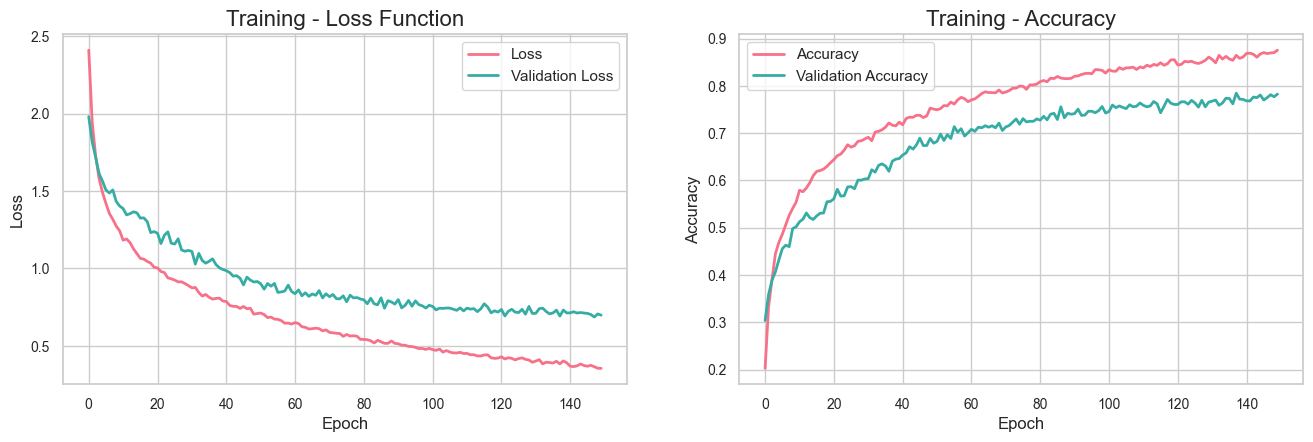

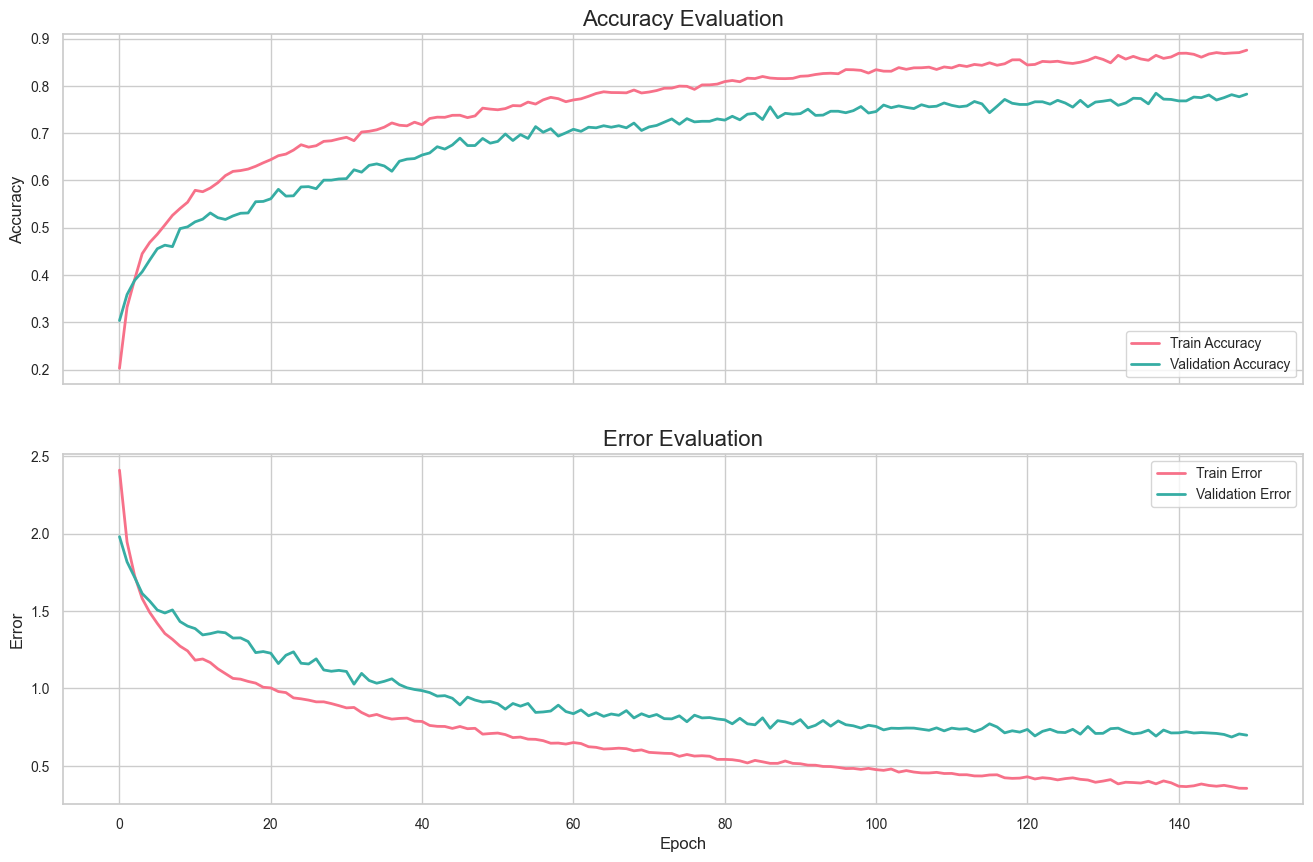

63/63 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.7905

Test accuracy: 0.7904999852180481


In [42]:
plot_history(history)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', test_acc)

In [43]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
print("Accuracy in Test Data : ", accuracy_score(y_test, y_predicted_labels))

Accuracy in Test Data :  0.7905


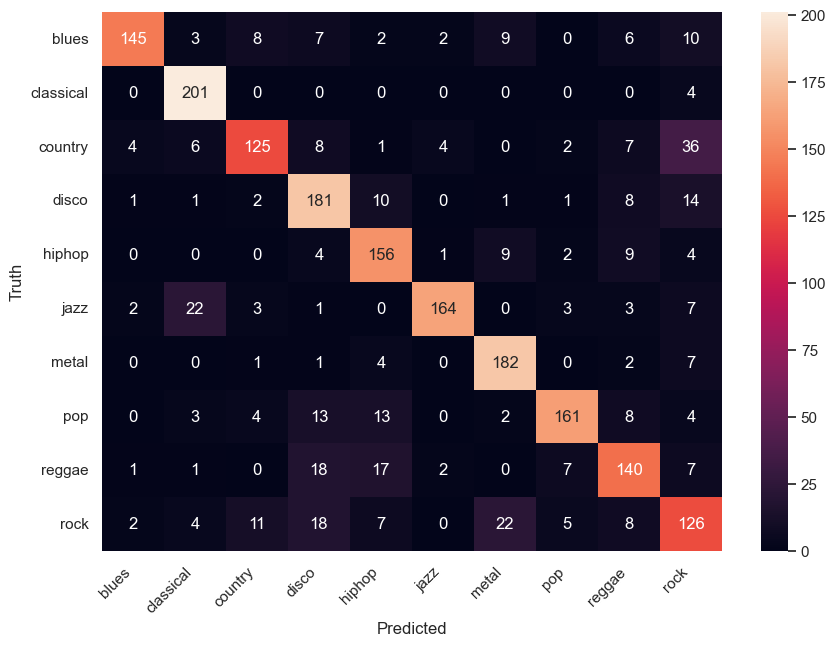

<Figure size 640x480 with 0 Axes>

In [44]:
plt.figure(figsize=(10, 7))
ax = sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

ax.set_xticklabels(genre_labels)
ax.set_yticklabels(genre_labels)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()
plt.savefig('heatmap.png')


In [45]:
X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(model, X_to_predict, y_to_predict)

Target: 8, Predicted label: [8]
Target: REGGAE, Predicted Index: REGGAE
